# Создаём свой когнитивный портрет

Привет! Сейчас мы погрузимся в мир **Science Art**, где наука -- а именно **искусственный интеллект** -- поможет нам создавать произведения искусства! А именно, мы познакомимся с техникой [когнитивного аддитивного портрета](http://bit.do/peopleblending)

<img src="https://raw.githubusercontent.com/shwars/FaceArt/master/notebooks/img/PhoBoGuy.png" width="30%"/>

В этой технике мы используем **[Face API](https://docs.microsoft.com/azure/cognitive-services/face/overview/?wt.mc_id=digigirlz-event-dmitryso)** для выделения ключевых точек лица на серии фотографий, с последующим поворотом и масштабированием фотографий таким образом, чтобы глаза на всех снимках совпадали. Совмещая такие снимки, мы получаем интересный визуальный эффект. 



### Используем Python и Azure Notebook

Для создания портрета мы будем использовать язык программирования Python. Не волнуйтесь, чтобы получить портрет вам не придётся писать свой код, а только выполнять существующий! Однако если вы умеете программировать (или научитесь это делать), то сможете получать намного более интересные визуальные эффекты! Научиться языку программирования Python можно с помощью [этого курса](http://pythontutor.ru).

Для выполнения нашей программы мы будем использовать так называемый [Azure Notebook](http://bit.do/whyaznb). Это доумент, в котором есть ячейки с текстом (одну из них вы сейчас читаете) и ячейки с кодом на языке Python - слева от таких ячеек есть надпись `In [..]`. Такую ячейку с кодом можно **выполнить**, нажав кнопку **RUN** в верхней панели или комбинацию клавиш **Ctrl-Enter**, при этом результат будет виден ниже под ячейкой. Попробуйте выполнить ячейку ниже, в которой мы вычисляем число секунд в сутках: 

In [1]:
24*60*60

86400

Для рисования портрета нам потребуется выполнить ряд ячеек с кодом. Это надо делать последовательно, дожидаясь завершения выполнения предыдущей ячейки (в процессе выполнения надпись слева выглядит как `In [*]`, а после выполнения звёздочка заменяется номером, показывающим, какой по счету была выполнена эта ячейка).

В упражнении ниже мы примерно описываем, что делает программа в каждой из ячеек: что-то будет вам понятно, что-то - нет. Не волнуйтесь, это нормально!

### Установка необходимых библиотек

Многие сложные операции в языке Python делаются с помощью специальных **библиотек**, т.е. написанных кем-то заранее программ. Для проведения манипуляций с изображениями нам необходима библиотека **OpenCV**, а также нужна библиотека для работы с **Face API**. В начале работы нам необходимо установить эти библиотеки (с помошью команд `pip`) и **импортировать** их, чтобы Python в дальнейшем видел все необходимые функции. 

Следующая ячейка с командами может работать довольно долго, потому что она скачивает и устанавливает библиотеки. Дождитесь результата её выполнения! Если вы увидите предупредительное сообщение *WARNING* -- не переживайте, это нормально.

In [18]:
import sys
!{sys.executable} -m pip install --quiet opencv-python azure-cognitiveservices-vision-face

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import os, requests, glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

### Извлекаем опорные точки лица

Для извлечения опорных точек лица мы используем [Microsoft Face API](https://azure.microsoft.com/services/cognitive-services/face/?wt.mc_id=digigirlz-event-dmitryso). С помощью него мы можем извлечь много полезной информации о лице, включая пол, возраст, углы поворота головы, эмоции и ключевые точки:

![Facial Landmarks](https://raw.githubusercontent.com/shwars/FaceArt/master/notebooks/img/landmarks.jpg)

Для более подробной информации о Face API и о том, как использовать его из других языков программирования, [посетите документацию на Microsoft Docs](https://docs.microsoft.com/ru-ru/azure/cognitive-services/face/index/?wt.mc_id=digigirlz-event-dmitryso).

Для использования Face API нам необходим специальный ключ, а также интернет-адрес для вызова сервиса (Endpoint URL). Самый простой способ его получить - запросить 7-дневный пробный ключ. При этом вам будет достаточно войти на страничку со своим **Microsoft Account**, и сказать **получить ключ*

### [Нажмите сюда для запроса ключа Face API](https://azure.microsoft.com/try/cognitive-services/my-apis/?api=face-api&wt.mc_id=digigirlz-event-dmitryso)

После этого вам нужно скопировать один из двух **ключей** (последовательность цифр) и **конечную точку** (которая напоминает интернет-адрес) в ячейку ниже: 

In [3]:
key = '--INSERT YOUR KEY HERE--' # ключ выглядит примерно так: 'e408f9b7c8e349ee8f5567dbea67df30'
endpoint = 'https://westus2.api.cognitive.microsoft.com' # убедитесь, что конечная точка соответствует тому, что вы увидели на странице


In [5]:
key = 'e408f9b6c8e34aee8f5567dbea67df30'
endpoint = 'https://westeurope.api.cognitive.microsoft.com'

Если вы скопировали все данные правильно, то после выполнения следующей ячейки вы увидите координаты опорных точек лица для следующей фотографии, взятой из интернет:

<img src="https://2016.dotnext-piter.ru/assets/images/people/soshnikov.jpg" width="20%"/>

Если вы не увидели координаты опорных точек, а вместо этого появилось сообщение об ошибке - проверьте правильность ключа и конечной точки. Только после того, как эта ячейка заработает, можно идти дальше.

In [10]:
import azure.cognitiveservices.vision.face as cf
from msrest.authentication import CognitiveServicesCredentials
cli = cf.FaceClient(endpoint,CognitiveServicesCredentials(key))
face_url = 'https://2016.dotnext-piter.ru/assets/images/people/soshnikov.jpg'
res = cli.face.detect_with_url(face_url,return_face_landmarks=True)
print(res[0].face_landmarks.as_dict())

{'eye_right_bottom': {'x': 172.7, 'y': 123.5}, 'eye_right_inner': {'x': 162.7, 'y': 120.8}, 'eyebrow_right_outer': {'x': 192.1, 'y': 106.6}, 'mouth_right': {'x': 177.8, 'y': 172.1}, 'eye_right_top': {'x': 171.3, 'y': 115.0}, 'eye_right_outer': {'x': 181.5, 'y': 118.5}, 'nose_root_right': {'x': 151.5, 'y': 124.3}, 'pupil_right': {'x': 170.9, 'y': 118.9}, 'eye_left_top': {'x': 112.3, 'y': 122.8}, 'eye_left_outer': {'x': 103.3, 'y': 128.9}, 'nose_left_alar_top': {'x': 131.9, 'y': 147.4}, 'eyebrow_right_inner': {'x': 157.2, 'y': 106.3}, 'nose_right_alar_top': {'x': 158.4, 'y': 143.8}, 'nose_root_left': {'x': 135.4, 'y': 126.3}, 'eye_left_inner': {'x': 122.4, 'y': 126.7}, 'pupil_left': {'x': 112.6, 'y': 126.7}, 'nose_left_alar_out_tip': {'x': 128.2, 'y': 159.3}, 'upper_lip_top': {'x': 150.3, 'y': 173.6}, 'nose_tip': {'x': 148.7, 'y': 158.4}, 'under_lip_bottom': {'x': 154.5, 'y': 193.0}, 'mouth_left': {'x': 121.6, 'y': 182.6}, 'nose_right_alar_out_tip': {'x': 167.0, 'y': 153.0}, 'eyebrow_lef

### Загружаем свои изображения

Для экспериментов нам нужны портретные изображения. Чтобы нарисовать свой портрет, вам потребуется загрузить в директорую `images` несколько (от 5 до 15, но не больше 20) своих фотографий. Для удобства в этой директории уже находятся пара фотографий - удалите их, если вы не хотите, чтобы они тоже участвовали в генерации портрета. Но можете и оставить :)

Для загрузки изображений надо перейти в предыдущую вкладку браузера, в которой находятся все файлы нашей библиотеки с примерами. Далее следуйте указаниям (показаны цифрами на рисунке):

1. Переходим в директорию `images`
2. Нажимаем в правом верхнем углу кнопку загрузки (со стрелкой) и выбираем **Upload from Computer**
3. Перетаскиваем картинки из проводника на нашем компьютере в открывшееся окошко, или нажимаем кнопку **Choose Files** и выбираем свои фотографии на диске компьютера
4. После этого все файлы должны появиться в списке ниже
5. Ставим галочку напротив **I trust the contents of those files**
6. Нажимаем **Upload**
7. После завершения загрузки надпись Upload поменяется на **Done**, нажимаем на кнопку ещё раз.

|![Upload Screen 1](.img/Upload1.PNG) | ![Upload Screen 2](.img/Upload2.PNG) |
| ---| ----|


Теперь, когда мы загрузили фотографии, посмотрим, как Face API справляется с обнаружением ключевых точек лица на этих фотографиях:

Анализируем изображение:  images/1-30.jpg


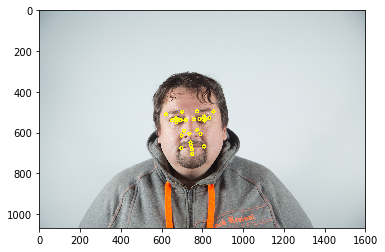

In [19]:
def imread(fn):
    im = cv2.imread(fn)
    return cv2.cvtColor(im,cv2.COLOR_BGR2RGB) if im is not None else None

fn = glob.glob('images/*')[0]
print('Анализируем изображение: ',fn)

img = imread(fn)
cli.face.detect_with_url(face_url)
with open(fn,'rb') as f:
    res = cli.face.detect_with_stream(f,return_face_landmarks=True)
for k,v in res[0].face_landmarks.as_dict().items():
    cv2.circle(img,(int(v['x']),int(v['y'])),7,(255,255,0),5)
plt.imshow(img)

Для наших экспериментов, давайте загрузим первые 20 изображений, пропустим их через Face API и извлечём ключевые точки. Мы сохраним картинки в список `images`, а коорданиты точек - в список `imagepoints`.

**Важно**: пробная версия Face API позволяет обрабатывать не более 20 запросов в минуту. Поэтому если вы захотите создавать портреты из более, чем 20 фотографий, то вам придётся усложнить код, добавив задержку между вызовами, чтобы количество запросов в минуту не превышало 20. В нашем случае мы просто ограничим количество обрабатываемых фотографий.

In [14]:
filenames = []
images = []
imagepoints = []
cli.face.detect_with_url(face_url)
for fn in glob.glob("images/*")[0:20]:
    print("Обрабатываю картинку {} ".format(fn),end='')
    try:
        with open(fn,'rb') as f:
            res = cli.face.detect_with_stream(f,return_face_landmarks=True)
    except:
        print(' - ОШИБКА - ',end='')
        res = []
    print(' найдено {} лиц'.format(len(res)))
    if len(res)>0:
        filenames.append(fn)
        images.append(imread(fn))
        imagepoints.append(res[0].face_landmarks.as_dict())

Обрабатываю картинку images/1-30.jpg  найдено 1 лиц
Обрабатываю картинку images/dsh_fall_sqr.JPG  найдено 1 лиц


**Важно**: Если вдруг вы увидите сообщение **ОШИБКА**, это означает, что Face API не смогло понять вашу фотографию. Возможно, формат изображения не поддерживается, или фотография слишком хорошего качества (у Face API есть ограничение на размер поддерживаемых фотографий). Попробуйте уменьшить изображение и загрузить его снова. Однако если несколько картинок оказались с ошибкой - не беда, главное, чтобы какое-то количество лиц было найдено!

Посмотрим на несколько загруженных нами изображений:

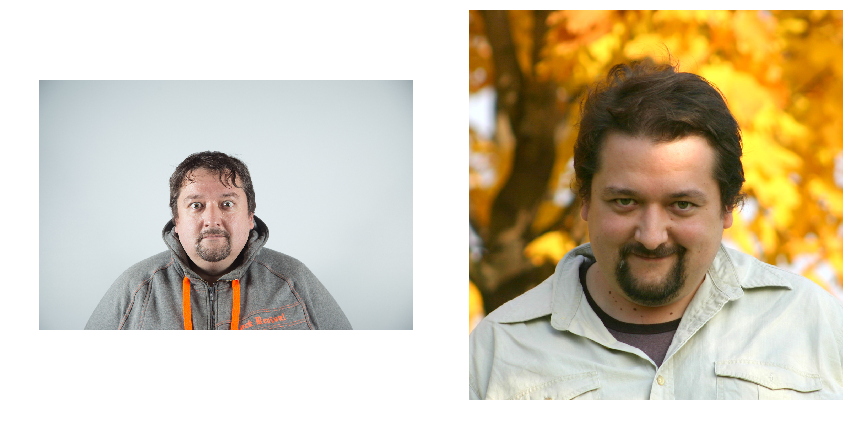

In [15]:
def display_images(l):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

display_images(images[:5])

## Аффинные преобразования

Чтобы выровнять все изображения по глазам, нам необходимо повернуть и масштабировать их. Для этого мы используем математическое понятие [**аффинного преобразования**](https://ru.wikipedia.org/wiki/Affine_transformation). Это сложное понятие, но вам не обязательно его детально понимать - главное, что мы можем применить небольшую математическую магию и совместить три точки исходного изображения (будем брать координаты двух глаз и середины рта) с заданными нами точками.

Будем ориентироваться на размер финального изображения $300\times300$ точек, тогда для координат глаз выберем точки $(130,120)$ и $(170,120)$. 

Магическая функция для выравнивания всех изображений будет иметь вид:

In [21]:
target_triangle = np.float32([[130.0,120.0],[170.0,120.0],[150.0,160.0]])
size = 300

def affine_transform(img,attrs):
    mc_x = (attrs['mouth_left']['x']+attrs['mouth_right']['x'])/2.0
    mc_y = (attrs['mouth_left']['y'] + attrs['mouth_right']['y']) / 2.0
    tr = cv2.getAffineTransform(np.float32([(attrs['pupil_left']['x'],attrs['pupil_left']['y']),
                                            (attrs['pupil_right']['x'],attrs['pupil_right']['y']),
                                            (mc_x,mc_y)]), target_triangle)                                
    return cv2.warpAffine(img,tr,(size,size))

Выровняем с её помощью все фотографии:

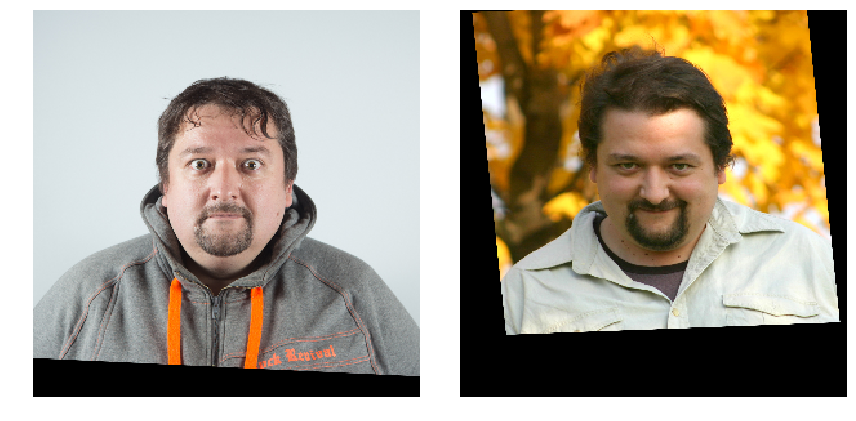

In [22]:
img_aligned = [affine_transform(i,a) for i,a in zip(images,imagepoints)]
display_images(img_aligned[:5])

## Смешивание изображений

Для получения результата нам осталось смешать эти изображения. Это несложная задача, но мы используем очень мощную функцию усреднения, которая позволит нам в дальнейшем присваивать разные веса отдельным изображениям. Для начала, посмотрим как смешиваются два первых изображения: 


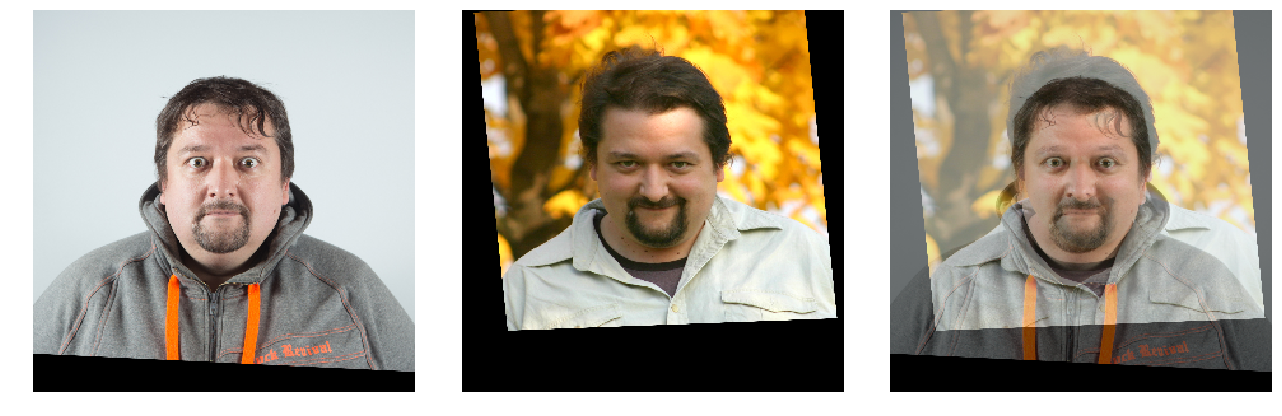

In [23]:
def merge(images,wts=None):
    res = np.zeros_like(images[0],dtype=np.float32)
    if wts is None:
        wts = np.ones(len(images))
    wts /= np.sum(wts)
    for n,i in enumerate(images):
        res += wts[n]*i.astype(np.float32)/255.0
    return res

display_images([img_aligned[0],img_aligned[1],merge(img_aligned[0:2])])

А теперь смешиваем все фотографии сразу, чтобы получить наш усредненный портрет!

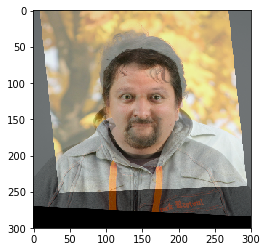

In [24]:
res = merge(img_aligned)
plt.imshow(res)

Мы можем сразу сгенерировать несколько изображений, смешивая картинки со случайными весами, чтобы потом выбрать из них лучший:

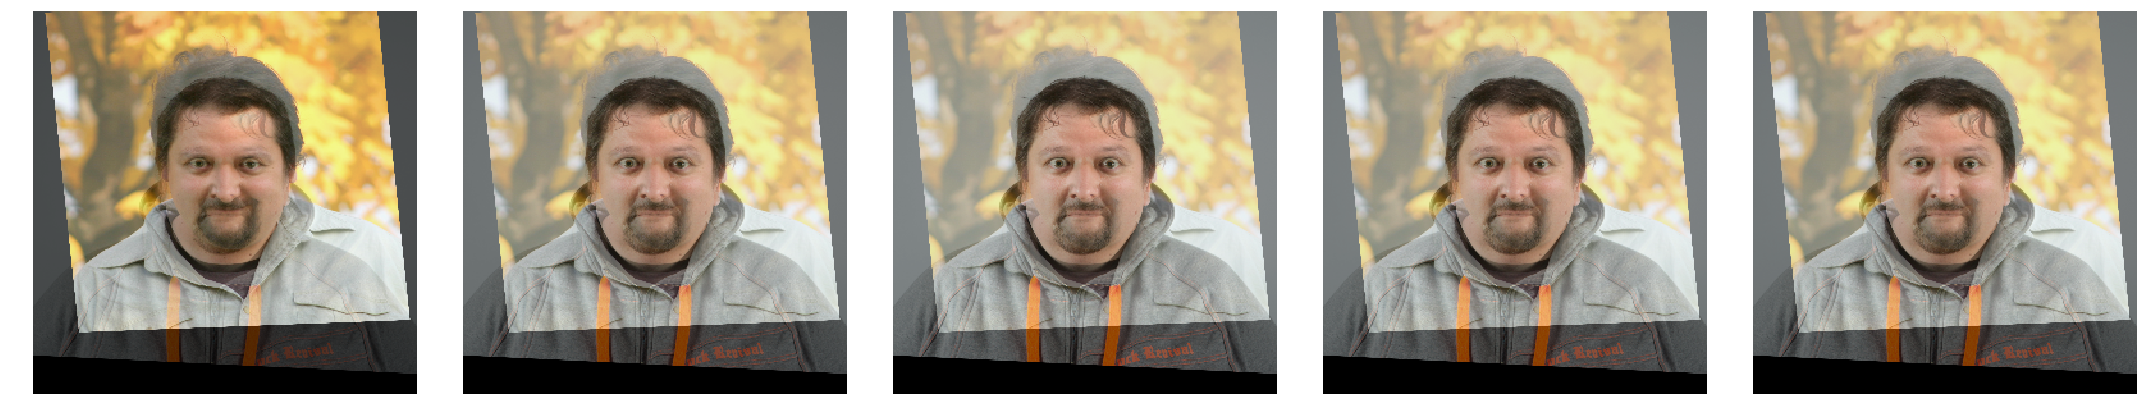

In [25]:
imgs = [merge(img_aligned,np.random.random(len(img_aligned))) for _ in range(5)]
display_images(imgs)

Наконец, запишем понравившийся нам портрет в JPG-файл, чтобы потом опубликовать его в instagram/twitter/vk. Для этого выполните следующую ячейку несколько раз, пока получившийся результат вас не удовлетворит:

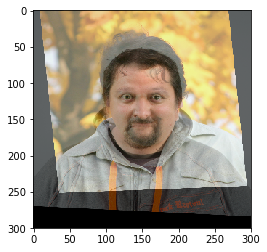

In [32]:
res = merge(img_aligned,np.random.random(len(img_aligned)))
plt.imshow(res)

А теперь выполните следующую ячейку, чтобы записать результат на диск:

In [36]:
cv2.imwrite('result.jpg',(cv2.cvtColor(res,cv2.COLOR_BGR2RGB)*255.0).astype(np.int))

True

Теперь вы можете снова перейти к соседней вкладке браузера - к той, где вы загружали изображения. Возможно, потребуется перезагрузить страницу (нажмите **F5**), и вы увидите файл `result.jpg` и сможете его посмотреть или загрузить.

Также всегда можно скопировать изображение с экрана компьютера с помощью инструмента **ножницы**...

## Учитесь программировать и продолжайте эксперименты!

Ура! Мы с вами научились создавать простейшие когнитивные портреты, накладывая фотографии для достижения интересного художественного эффекта! Вы можете поэкспериментировать с разными наборами фотографий, чтобы получить разные эффекты:

* Используйте фотографии одного человека разного возраста, чтобы получить эффект "омоложения"
* Комбинируйте фотографии разных людей (5 фотографий одного человека и 5 другого), чтобы смешать их вместе!
* Попробуйте смешать много фотографий разных людей

Смешивание фотографий - это лишь один приём, который можно использовать, получив координаты опорных точек лица. Вы можете делать и другие, например, поэкспериментируйте с расположением точек лица по какому-нибудь правилу, например, по окружности. Изучив возможности Python и библиотеки OpenCV по обработке изображений, вы сможете разнообразить свой творческий инструментарий, и получать действительно интересные эффекты.

## Поделитесь результатами!

Пожалуйста, обязательно делитесь полученными результатами! Лично мне, как автору технологии **peopleblendig**, будет очень интересно посмотреть на ваши результаты - например, вы можете [послать мне получившуюся картинку сообщением в вк](http://vk.com/shwars). Но ещё лучше - разместите их в социальных сетях с хештегом **#peopleblending**. Например:

> Ого, смотрите что я сотворил с использованием технологии #peopleblending http://bit.do/peopleblending!

Не останавливайтесь на достигнутом, творите и будьте счастливы!